**Results for sample size experiments**

In [262]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [263]:
mlflow.set_tracking_uri('http://localhost:3336')
client = MlflowClient()

model_names = ['Efficient', 'Plugin']
experiment_names = ['Synthetic_'+ model_name for model_name in model_names]
experiments = {exp.name: exp.experiment_id for exp in client.search_experiments()}

In [264]:
metric_names = ['regret']
param_names = ['global_seed', 'gamma', 'gamma_data', 'n_samples_train']
data_dict = {}

for experiment_name in experiment_names:
    if experiment_name in experiments:
        experiment_id = experiments[experiment_name]
        # Get all runs for the experiment
        runs = client.search_runs(experiment_ids=[experiment_id])
        # Extract metrics and parameters
        runs_data = [
            {
                **run.data.metrics,
                **run.data.params,
                'run_id': run.info.run_id
            }
            for run in runs
        ]
        combined_df = pd.DataFrame(runs_data)
        
        if not combined_df.empty:
            # Filter the DataFrame to only include the desired metrics and parameters
            columns_to_include = ['run_id'] + metric_names + param_names
            filtered_df = combined_df[columns_to_include]
            data_dict[experiment_name.split("/")[0]] = filtered_df
        else:
            print(f"No runs found for experiment {experiment_name}.")
    else:
        print(f"Experiment {experiment_name} does not exist.")


efficient_estimator = data_dict['Synthetic_Efficient'].drop(columns=['run_id'])
plugin_estimator = data_dict['Synthetic_Plugin'].drop(columns=['run_id'])

efficient_estimator['regret'] = pd.to_numeric(efficient_estimator['regret'], errors='coerce')
plugin_estimator['regret'] = pd.to_numeric(plugin_estimator['regret'], errors='coerce')

efficient_estimator['gamma'] = pd.to_numeric(efficient_estimator['gamma'], errors='coerce')
plugin_estimator['gamma'] = pd.to_numeric(plugin_estimator['gamma'], errors='coerce')


efficient_estimator['gamma_data'] = pd.to_numeric(efficient_estimator['gamma_data'], errors='coerce')
plugin_estimator['gamma_data'] = pd.to_numeric(plugin_estimator['gamma_data'], errors='coerce')

efficient_estimator['n_samples_train'] = pd.to_numeric(efficient_estimator['n_samples_train'], errors='coerce')
plugin_estimator['n_samples_train'] = pd.to_numeric(plugin_estimator['n_samples_train'], errors='coerce')


**Compute mean and standard deviation of regret over randomized policy** 

In [265]:
efficient_mean = efficient_estimator.groupby('n_samples_train')['regret'].mean()
efficient_std = efficient_estimator.groupby('n_samples_train')['regret'].std()

plugin_mean = plugin_estimator.groupby('n_samples_train')['regret'].mean()
plugin_std = plugin_estimator.groupby('n_samples_train')['regret'].std()

**Plot the results**

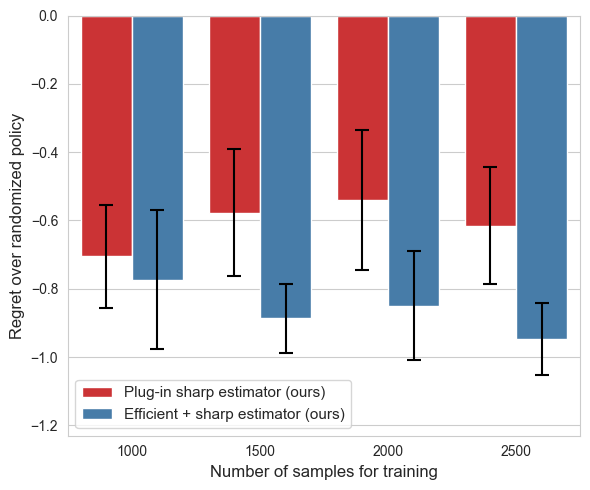

In [266]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame to store all data for plotting
df = pd.DataFrame({
    'n_samples_train': efficient_mean.index,
    'Plugin_Mean': plugin_mean.values,
    'Plugin_Std': plugin_std.values,    
    'Efficient_Mean': efficient_mean.values,
    'Efficient_Std': efficient_std.values
})

# Prepare data for plotting
plugin = df[['n_samples_train', 'Plugin_Mean', 'Plugin_Std']].rename(
    columns={'Plugin_Mean': 'Mean', 'Plugin_Std': 'Std'}
)
plugin['Model'] = 'Plug-in sharp estimator (ours)'
plugin['Std'] = plugin['Std'] / np.sqrt(10)  # Standard error adjustment


efficient = df[['n_samples_train', 'Efficient_Mean', 'Efficient_Std']].rename(
    columns={'Efficient_Mean': 'Mean', 'Efficient_Std': 'Std'}
)
efficient['Model'] = 'Efficient + sharp estimator (ours)'
efficient['Std'] = efficient['Std'] / np.sqrt(10)  # Standard error adjustment


# Combine both data for plotting
plot_data = pd.concat([plugin, efficient])

# Set up the Seaborn color palette
palette = sns.color_palette("Set1", n_colors=2)

# Create the plot
plt.figure(figsize=(6,5))
barplot = sns.barplot(
    data=plot_data,
    x='n_samples_train',
    y='Mean',
    hue='Model',
    palette=palette,
    errorbar=None
)

# Add error bars
for container, model in zip(barplot.containers, plot_data['Model'].unique()):
    subset = plot_data[plot_data['Model'] == model]
    x_positions = [bar.get_x() + bar.get_width() / 2 for bar in container]
    plt.errorbar(
        x=x_positions,
        y=subset['Mean'],
        yerr=subset['Std'],
        fmt='none',
        c='black',
        capsize=5,
        capthick=1.5,
        elinewidth=1.5
    )

# Add labels and legend
plt.xlim(-0.5, 3.5)
plt.ylim(-1.23,0)
plt.xlabel('Number of samples for training', fontsize=12)
plt.ylabel('Regret over randomized policy', fontsize=12)
plt.legend(loc='lower left', frameon=True, fontsize=11)
plt.tight_layout()

# Show the plot
plt.show()
